In [1]:
# Data Handling and Transformation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import breaks_cusumolsresid, het_breuschpagan, het_goldfeldquandt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ruptures as rpt

In [2]:
# Laden der Daten
df = pd.read_pickle('data/filtered_merged_data.pkl')
# drop unnötige Spalten von tesla stock data
df = df.drop(columns=['Open', 'High', 'Low', 'Close'])
df.head()

,Date,Adj Close,Volume,sentiment_numeric,likes_count,retweets_count,replies_count
13,2015-01-30,13.573333,45105000.0,-1.0,796.0,462.0,243.0
14,2015-02-02,14.062667,62238000.0,0.0,0.0,0.0,0.0
15,2015-02-03,14.557333,72393000.0,0.0,0.0,0.0,0.0
16,2015-02-04,14.570000,49581000.0,0.0,0.0,0.0,0.0
17,2015-02-05,14.732667,52843500.0,0.0,0.0,0.0,0.0


In [3]:
df.info()   

<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 13 to 1797
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1373 non-null   datetime64[ns]
 1   Adj Close          1373 non-null   float64       
 2   Volume             1373 non-null   float64       
 3   sentiment_numeric  1373 non-null   float64       
 4   likes_count        1373 non-null   float64       
 5   retweets_count     1373 non-null   float64       
 6   replies_count      1373 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 85.8 KB


In [4]:
df.describe()

,Date,Adj Close,Volume,sentiment_numeric,likes_count,retweets_count,replies_count
count,1373,1373.000000,1.373000e+03,1373.000000,1.373000e+03,1373.000000,1373.000000
mean,2017-10-21 00:50:20.538965760,21.195553,1.160255e+08,-0.004330,1.267089e+05,15439.541151,3469.287691
min,2015-01-30 00:00:00,9.578000,1.062000e+07,-1.000000,0.000000e+00,0.000000,0.000000
25%,2016-06-10 00:00:00,15.057333,6.252600e+07,-0.200000,0.000000e+00,0.000000,0.000000
50%,2017-10-19 00:00:00,18.008667,8.958000e+07,0.000000,1.698200e+04,2489.000000,771.000000
75%,2019-03-05 00:00:00,22.337999,1.345560e+08,0.177778,1.079990e+05,13116.000000,3375.000000
max,2020-07-14 00:00:00,102.976669,9.140820e+08,1.000000,2.829985e+06,397381.000000,98612.000000
std,NaN,11.485527,8.716806e+07,0.494637,2.749759e+05,36970.423217,7845.317739



Starke Varianz bei den Tweet-Daten: Die hohe Varianz bei den „likes_count“, „retweets_count“ und „replies_count“ zeigt, dass einige Tweets von Elon Musk extrem viel Aufmerksamkeit bekommen haben, während andere weniger Beachtung fanden. Das könnte darauf hindeuten, dass bestimmte Tweets eine stärkere Wirkung auf den Aktienkurs haben könnten.

Sentiment-Index: Der durchschnittliche Sentiment-Wert ist nahe bei null, was darauf hinweist, dass Musks Tweets im Durchschnitt neutral bewertet wurden, aber auch eine hohe Varianz aufweisen.

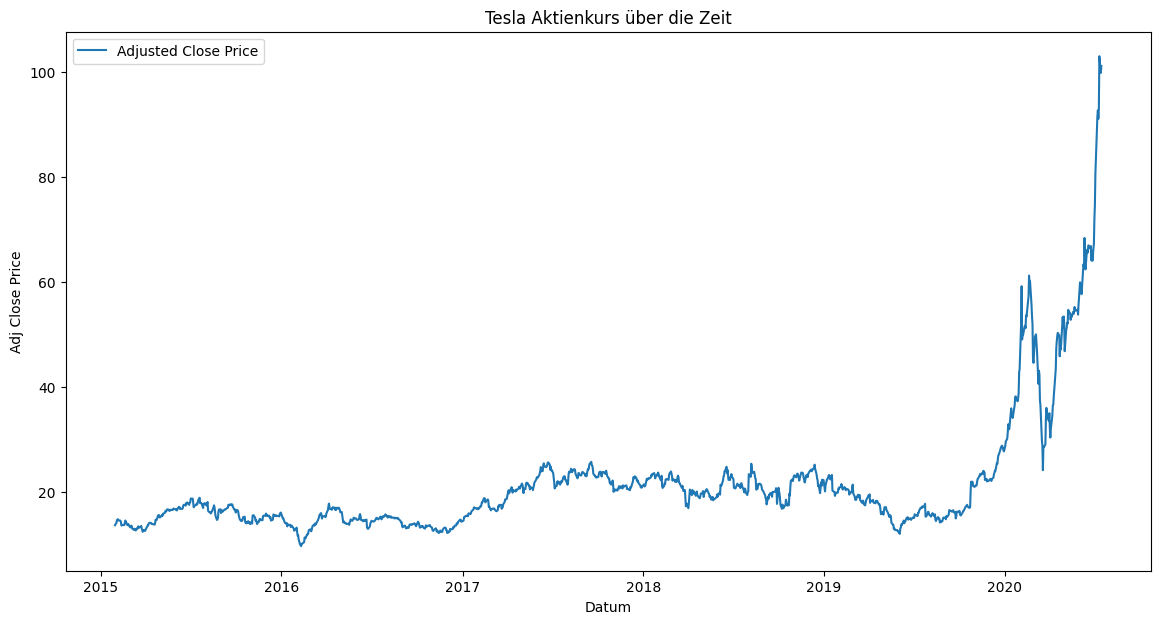

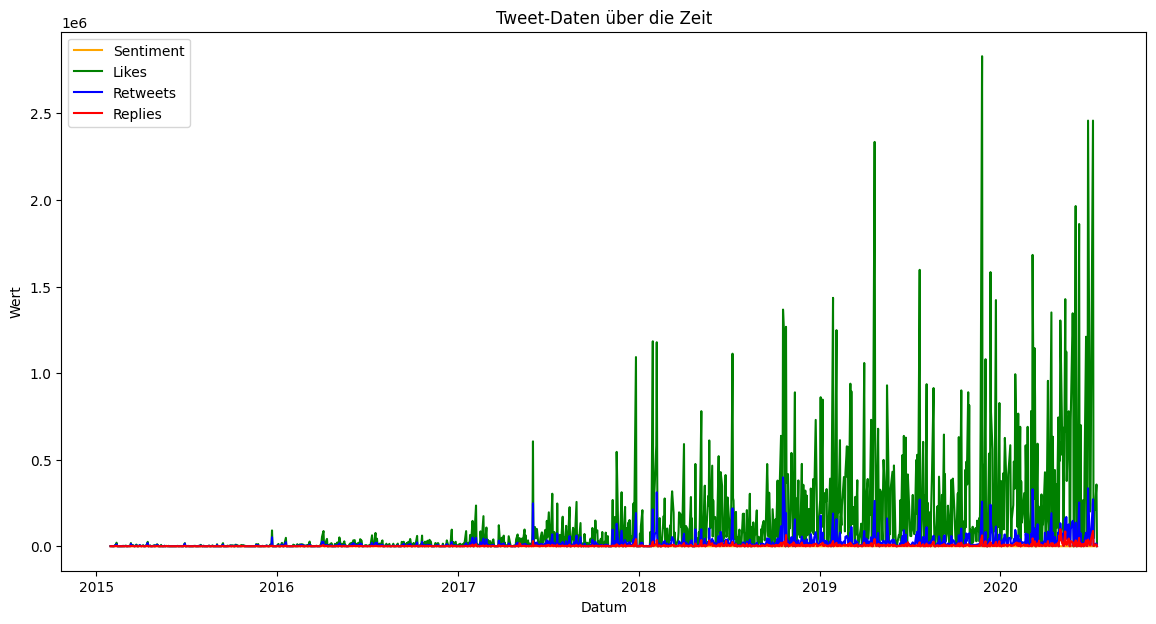

In [5]:
# Tesla-Aktienkurs über die Zeit
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Adj Close'], label='Adjusted Close Price')
plt.title('Tesla Aktienkurs über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

# Sentiment, Likes, Retweets und Replies über die Zeit
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['sentiment_numeric'], label='Sentiment', color='orange')
plt.plot(df['Date'], df['likes_count'], label='Likes', color='green')
plt.plot(df['Date'], df['retweets_count'], label='Retweets', color='blue')
plt.plot(df['Date'], df['replies_count'], label='Replies', color='red')
plt.title('Tweet-Daten über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Wert')
plt.legend()
plt.show()



Jährliche Zyklen und Strukturbrüche: Die identifizierten Zyklen und Strukturbrüche (z.B. Anfang 2016, Ende 2019, COVID-19) sind wichtig. Diese müssen in der weiteren Analyse, besonders bei der Modellierung und bei der Berücksichtigung von Dummies oder strukturellen Änderungen, berücksichtigt werden.

Langfristiger Aufwärtstrend: Ab Ende 2019 ist ein deutlicher Anstieg im Aktienkurs erkennbar. Das könnte auf die positive Erwartungshaltung in Bezug auf Teslas Geschäftsentwicklung und die Aufnahme in den S&P 500 hinweisen.

In [6]:
# Korrelationen berechnen
correlation_matrix = df[['Adj Close', 'sentiment_numeric', 'likes_count', 'retweets_count', 'replies_count']].corr()
correlation_matrix


,Adj Close,sentiment_numeric,likes_count,retweets_count,replies_count
Adj Close,1.000000,0.032999,0.364546,0.265675,0.384395
sentiment_numeric,0.032999,1.000000,-0.024714,-0.040831,-0.014893
likes_count,0.364546,-0.024714,1.000000,0.912529,0.845908
retweets_count,0.265675,-0.040831,0.912529,1.000000,0.772122
replies_count,0.384395,-0.014893,0.845908,0.772122,1.000000



Hohe Korrelation zwischen den sozialen Interaktionen (likes, retweets, replies): Das ist zu erwarten, da diese Variablen stark miteinander verknüpft sind. In der Modellierung könnte es notwendig sein, diese Korrelationen zu behandeln, um Multikollinearität zu vermeiden.

Schwache Korrelationen zwischen „Adj Close“ und den sozialen Interaktionen: Dies könnte darauf hinweisen, dass die Effekte der Tweets auf den Aktienkurs nicht linear oder sofort sichtbar sind. Es könnte notwendig sein, lags oder andere Transformationen der Daten zu verwenden, um diese Beziehungen besser zu verstehen.

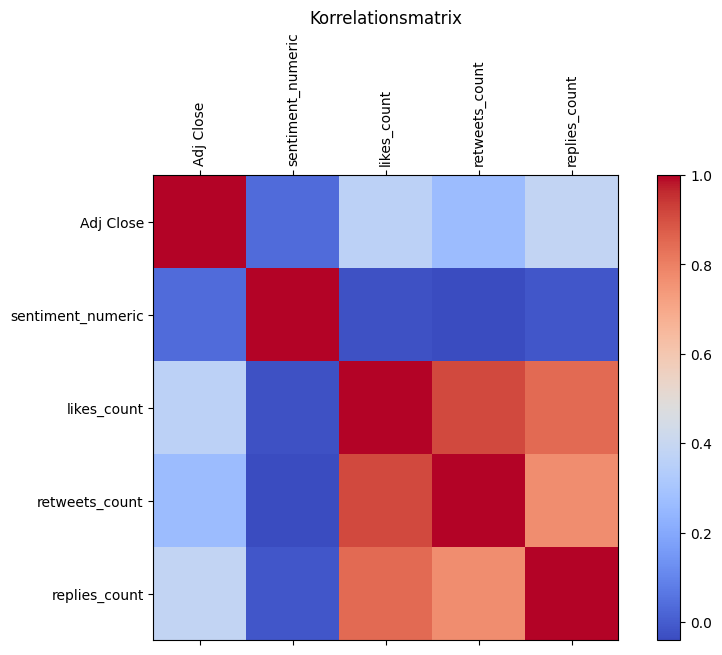

In [7]:
# correlation_matrix als Heatmap darstellen
plt.figure(figsize=(10,6))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.title('Korrelationsmatrix')
plt.show()


## 1. Stationaritätstest
### Augmented Dickey-Fuller-Test (ADF)
Stationarität ist eine Grundvoraussetzung für Zeitreihenmodelle wie ARIMA (was wir später in dieser Studie verwenden werden). Wir führen den Augmented Dickey-Fuller-Test (ADF) durch, um zu überprüfen, ob unsere Zeitreihe stationär ist. Wenn sie nicht stationär ist, müssen wir sie differenzieren.

In [8]:
# Stationaritätstest mit Augmented Dickey-Fuller Test für den Aktienkurs
result = adfuller(df['Adj Close'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("Die Zeitreihe ist nicht stationär. Eine Differenzierung ist nötig.")
else:
    print("Die Zeitreihe ist stationär.")

ADF Statistic: 4.065041096385912
p-value: 1.0
Die Zeitreihe ist nicht stationär. Eine Differenzierung ist nötig.


Die ADF-Statistik und der p-Wert zeigen, ob die Zeitreihe stationär ist. In unserem Fall ist die Zeitreihe nicht stationär, da der p-Wert größer als 0.05 ist. Dies bedeutet, dass wir die Zeitreihe differenzieren müssen, um sie stationär zu machen.

### Differenzierung

In [9]:
# Differenzierung der Zeitreihe
df['Close_diff'] = df['Adj Close'].diff()

# Erneute Überprüfung der Stationarität nach der Differenzierung
result_diff = adfuller(df['Close_diff'].dropna())

print('ADF Statistic nach Differenzierung:', result_diff[0])
print('p-value nach Differenzierung:', result_diff[1])

if result_diff[1] > 0.05:
    print("Die Zeitreihe ist weiterhin nicht stationär.")
else:
    print("Die Zeitreihe ist jetzt stationär.")

# dropna() entfernt den NaN-Wert, der durch die Differenzierung entstanden ist
df.dropna(inplace=True)

# Überprüfung auf NA-Werte
if df.isna().sum().sum() == 0:
    print("\nEntstandene Na-Werte nach Differenzierung wurden erfolgreich gelöscht. \nDer DataFrame hat keine NA-Werte.")
else:
    print("\nEtwas stimmt nicht. Der DataFrame hat die folgenden NA-Werte:")
    print(df.isna().sum())

ADF Statistic nach Differenzierung: -5.748412128821086
p-value nach Differenzierung: 6.045470308399558e-07
Die Zeitreihe ist jetzt stationär.

Entstandene Na-Werte nach Differenzierung wurden erfolgreich gelöscht. 
Der DataFrame hat keine NA-Werte.


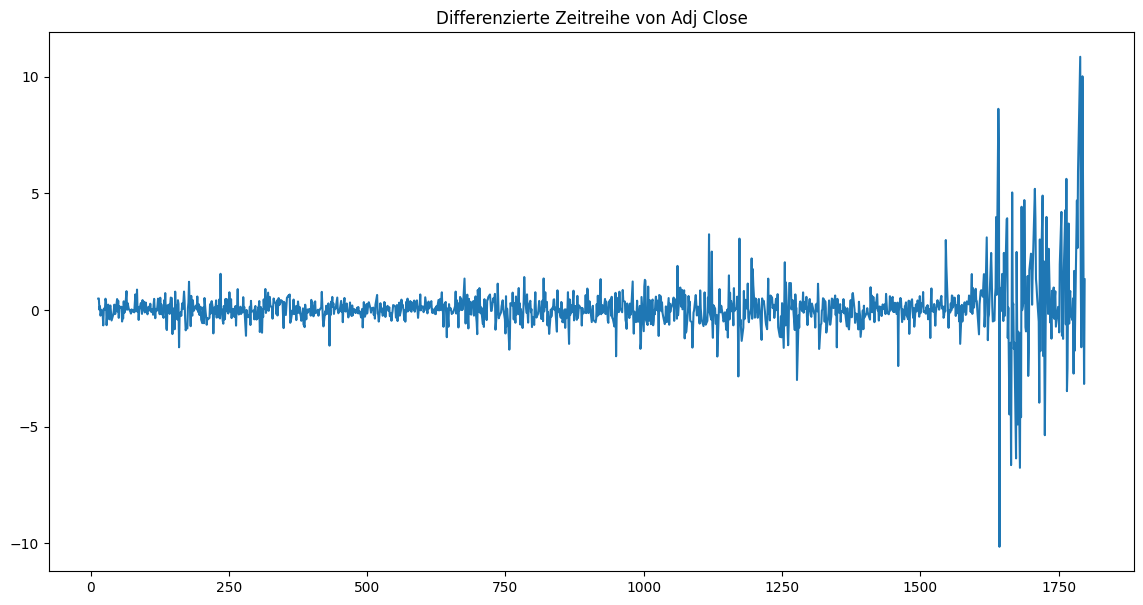

In [10]:
# Plot der differenzierten Zeitreihe
plt.figure(figsize=(14, 7))
plt.plot(df['Close_diff'])
plt.title('Differenzierte Zeitreihe von Adj Close')
plt.show()

# 2. Überprüfung auf Autokorrelation und Heteroskedastizität

### Überprüfung auf Autokorrelation:

Wir verwenden den Durbin-Watson-Test, um zu prüfen, ob eine Autokorrelation in den Residuen vorliegt.
Alternativ können wir auch die Autokorrelationsfunktion (ACF) betrachten.Die ACF bietet eine umfassendere Analyse der Autokorrelation über verschiedene Lags hinweg und wird in der Zeitreihenanalyse verwendet.



#### Durbin-Watson-Test

Die Durbin-Watson-Statistik ist ein Test, der verwendet wird, um die Autokorrelation der Residuen in einem Regressionsmodell zu überprüfen. Autokorrelation bedeutet, dass die Fehler oder Residuen (die Differenz zwischen den tatsächlichen und den vorhergesagten Werten) eines Modells in aufeinander folgenden Beobachtungen korreliert sind.

Die Durbin-Watson-Statistik kann Werte zwischen 0 und 4 annehmen:

Ein Wert von 2 bedeutet, dass keine Autokorrelation vorliegt.
Ein Wert nahe 0 deutet auf eine starke positive Autokorrelation hin.
Ein Wert nahe 4 deutet auf eine starke negative Autokorrelation hin.

In [11]:
# Durbin-Watson-Test für Autokorrelation
dw_stat = sm.stats.durbin_watson(df['Close_diff'].dropna())
print(f"Durbin-Watson-Statistik: {dw_stat}")

Durbin-Watson-Statistik: 1.8719718445478222


Der Wert 1.87 liegt sehr nahe bei 2. Das deutet darauf hin, dass in Ihrer Zeitreihe df['Close_diff'] praktisch keine Autokorrelation vorhanden ist. Da der Wert leicht unter 2 liegt, könnte man eine sehr schwache positive Autokorrelation vermuten, aber diese wäre wahrscheinlich nicht signifikant.

#### ACF (Autokorrelationsfunktion)

Die ACF misst die Korrelation zwischen den Werten einer Zeitreihe über verschiedene Zeitverzögerungen (Lags) hinweg. Sie zeigt, wie stark aktuelle Werte mit Werten aus der Vergangenheit korreliert sind, nicht nur für den ersten Lag (wie der Durbin-Watson-Test), sondern für viele Lags.
Anwendung: Die ACF wird häufig in der Zeitreihenanalyse verwendet, um das Muster und die Struktur der Autokorrelation über verschiedene Zeitverzögerungen hinweg zu verstehen. Sie liefert ein vollständiges Bild der Autokorrelationsstruktur über verschiedene Lags hinweg.


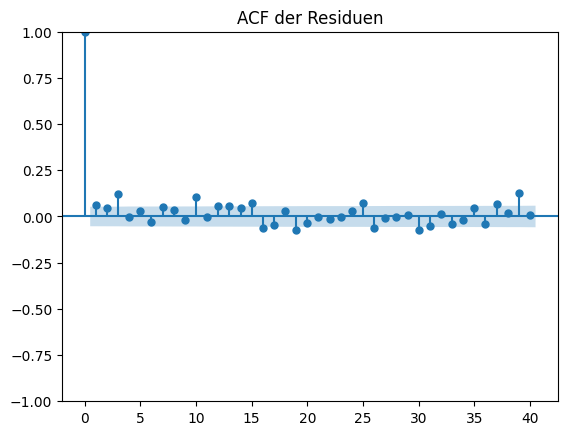

In [12]:
# ACF plotten
plot_acf(df['Close_diff'].dropna(), lags=40)  # lags gibt die Anzahl der Verzögerungen an, die du betrachten möchtest
plt.title('ACF der Residuen')
plt.show()

Das ACF-Plot zeigt, dass die Residuen deines Modells keine signifikante Autokorrelation aufweisen, was darauf hindeutet, dass das Modell in Bezug auf die Annahme unabhängiger Residuen gut spezifiziert ist. Dies unterstützt die vorherige Beobachtung aus der Durbin-Watson-Statistik, die nahe bei 2 lag und ebenfalls auf das Fehlen von Autokorrelation hinwies.


Erster Lag (Lag 0):
Der ACF-Wert bei Lag 0 ist immer 1, da es die Autokorrelation der Residuen mit sich selbst darstellt. Dies erklärt den hohen Wert bei Lag 0.

Lags 1 bis 40:
Die Autokorrelationswerte für die Lags 1 bis 40 scheinen alle nahe bei 0 zu liegen und fallen innerhalb des blauen Konfidenzintervalls.
Dies deutet darauf hin, dass es keine signifikante Autokorrelation in den Residuen über diese Lags hinweg gibt. Das bedeutet, dass die Residuen weitgehend unkorreliert sind, was ein gutes Zeichen für das Regressionsmodell ist.

Konfidenzintervalle (blaue Schattenbereiche):
Die blauen Schattenbereiche stellen das Konfidenzintervall dar (normalerweise etwa 95%). Wenn die Punkte innerhalb dieses Intervalls liegen, bedeutet dies, dass die Autokorrelation statistisch nicht signifikant ist.

Da fast alle Punkte innerhalb dieses Intervalls liegen, gibt es keinen Hinweis auf signifikante Autokorrelation in den Residuen.

### Überprüfung auf Heteroskedastizität

Wir verwenden den Breusch-Pagan-Test, um zu überprüfen, ob Heteroskedastizität in den Residuen vorliegt. Breusch-Pagan-Test nutzt rekursiven residient, gut mit R oder Python zu verwenden (braucht viele Rechnleistung).


In [13]:
# Breusch-Pagan-Test für Heteroskedastizität
model_bp = sm.OLS(df['Close_diff'], sm.add_constant(df[['sentiment_numeric', 'likes_count', 'retweets_count', 'replies_count']])).fit()
bp_test = het_breuschpagan(model_bp.resid, model_bp.model.exog)
labels = ['LM-Statistik', 'LM-Test p-Wert', 'F-Statistik', 'F-Test p-Wert']
print(dict(zip(labels, bp_test)))

{'LM-Statistik': 162.6932192318899, 'LM-Test p-Wert': 3.866001741335573e-34, 'F-Statistik': 45.977090806671015, 'F-Test p-Wert': 2.79404802276171e-36}


Die extrem niedrigen p-Werte in beiden Tests (LM-Test und F-Test) deuten darauf hin, dass es sehr starke Beweise für das Vorhandensein von Heteroskedastizität in deinem Regressionsmodell gibt. Dies bedeutet, dass die Annahme der konstanten Varianz der Residuen verletzt ist und du möglicherweise Maßnahmen ergreifen musst, um dieses Problem zu beheben, wie zum Beispiel eine Transformation der abhängigen Variablen oder die Verwendung robuster Standardfehler.

#### Goldfeld-Quandt-Test

Der Goldfeld-Quandt-Test teilt die Daten in zwei Gruppen auf, basierend auf einer erklärenden Variablen, und vergleicht die Varianz der Residuen in diesen beiden Gruppen. Die Grundidee ist, dass man unter der Annahme der Homoskedastizität (konstante Varianz) erwarten würde, dass die Varianz in beiden Gruppen ähnlich ist. Wenn jedoch eine signifikante Differenz in den Varianzen besteht, spricht dies für Heteroskedastizität.

Wird v. Frau Bönte meistens verwendet.

In [14]:
# Goldfeld-Quandt-Test durchführen
gq_test = het_goldfeldquandt(model_bp.resid, model_bp.model.exog)

labels = ['F-Statistic', 'p-value']
print(dict(zip(labels, gq_test)))

{'F-Statistic': 13.179022262212646, 'p-value': 1.997649826479168e-200}


Das Ergebnis des Goldfeld-Quandt-Tests unterstützt die Ergebnisse des Breusch-Pagan-Tests und weist stark auf das Vorhandensein von Heteroskedastizität in deinem Regressionsmodell hin. Beide Tests zeigen extrem niedrige p-Werte, was bedeutet, dass es sehr wahrscheinlich ist, dass die Varianz der Fehlerterme nicht konstant ist. Dies bestätigt die Notwendigkeit, Maßnahmen zu ergreifen, um mit der Heteroskedastizität umzugehen, wie zum Beispiel die Verwendung robuster Standardfehler, eine Transformation der Variablen, oder das Erstellen eines anderen Modells, das besser zu den Daten passt.

F-Statistic: Der Wert von 13.179 für die F-Statistik zeigt eine signifikante Differenz in den Varianzen der beiden Gruppen an. Ein hoher Wert der F-Statistik deutet darauf hin, dass die Varianz in einer der beiden Gruppen deutlich größer ist als in der anderen.
p-value: Der p-Wert ist extrem niedrig (1.9976e-200), was darauf hinweist, dass diese Differenz in den Varianzen statistisch hoch signifikant ist. Mit einem so niedrigen p-Wert kannst du die Nullhypothese, dass die Varianzen in den beiden Gruppen gleich sind (keine Heteroskedastizität), mit sehr hoher Sicherheit ablehnen.

Es ist besser, die Heteroskedastizität erst dann zu behandeln, wenn das endgültige Modell spezifiziert ist, einschließlich der Berücksichtigung von Strukturbrüchen, Multikollinearität und der möglichen Verwendung von Lags. Das ist methodisch fundiert und praxisnah.

Hier ist der Grund dafür:

Modellspezifikation: Wenn das Modell weiter verfeinert ist (z.B. durch das Hinzufügen von Dummy-Variablen, das Behandeln von Multikollinearität oder das Einfügen von Lags), könnte sich die Heteroskedastizität ändern. Es ist also sinnvoll, die Heteroskedastizität erst dann zu behandeln, wenn das endgültiges Modell spezifiziert ist.

Effizienz der Anpassungen: Robustheit und andere Anpassungen zur Behandlung von Heteroskedastizität sollten auf dem endgültigen Modell basieren, da sich die Eigenschaften der Residuen während der Modellspezifikation ändern können.

# 3. Erstellung von Dummy-Variablen für diese Strukturbrüche

### Identifizierung der Strukturbrüche

Hier sind einige der gängigsten Methoden:
von den Vorlesungen:
1. Chow-Test
Der Chow-Test ist ein klassischer Test, um zu prüfen, ob es einen Strukturbruch in einem bestimmten Punkt der Zeitreihe gibt. Er testet, ob die Regressionskoeffizienten vor und nach einem bestimmten Zeitpunkt signifikant unterschiedlich sind.
2. CUSUM-Test (Cumulative Sum of Recursive Residuals)
Der CUSUM-Test prüft auf kumulative Abweichungen der Residuen über die Zeit. Wenn die Abweichungen zu groß werden, deutet das auf einen Strukturbruch hin.

nach etwas recherchieren 
Bai-Perron-Test
Der Bai-Perron-Test ist eine leistungsfähige Methode, um multiple Strukturbrüche zu identifizieren. Dieser Test kann gleichzeitig mehrere Brüche an verschiedenen Zeitpunkten erkennen und ist besonders nützlich, wenn man keine klare Vorstellung hat, wann die Strukturbrüche aufgetreten sein könnten. Der Bai-Perron-Test ist etwas anspruchsvoller.

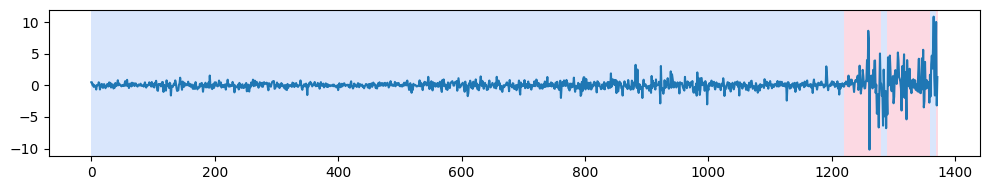

Gefundene Strukturbruchstellen (Index): [1220, 1280, 1290, 1360, 1370, 1372]


In [15]:
# Wir verwenden die Differenzierte Zeitreihe ('Close_diff') für den Test
signal = df['Close_diff'].dropna().values

# Erstelle ein Modell mit konstanter Varianz
algo = rpt.Binseg(model="l2").fit(signal)
result = algo.predict(n_bkps=5)  # n_bkps gibt die Anzahl der erwarteten Brüche an

# Visualisierung der Brüche
rpt.display(signal, result)
plt.show()

# Ausgabe der gefundenen Bruchstellen
print("Gefundene Strukturbruchstellen (Index):", result)

Die Ergebnisse des Bai-Perron-Tests geben uns bereits eine sehr gute Grundlage für die Identifizierung der Strukturbrüche. Die identifizierten Bruchstellen stimmen gut mit den bekannten Ereignissen überein, die bereits durch Beobachtungen festgestellt wurden:
Ende 2019: Starke Preissteigerung bis zum Beginn der COVID-19-Pandemie.
März 2020 (COVID-19): Starke Preissenkung durch den externen Schock der Pandemie.
Juli 2020: Eine starke Preissteigerung, vermutlich in Zusammenhang mit der bevorstehenden Aufnahme von Tesla in den S&P 500.

### CUSUM-Test
Da die Dummies die von Bai-Perron-Tests vorgeschlagene Dummies zu spezifisch sind und nicht leicht zu erstellen, werden wir mit Hilfe von CUSUM die Dummies manuell erstellen.

CUSUM-Test statistic: 1.2052503747884582
p-value: 0.10945150069282013


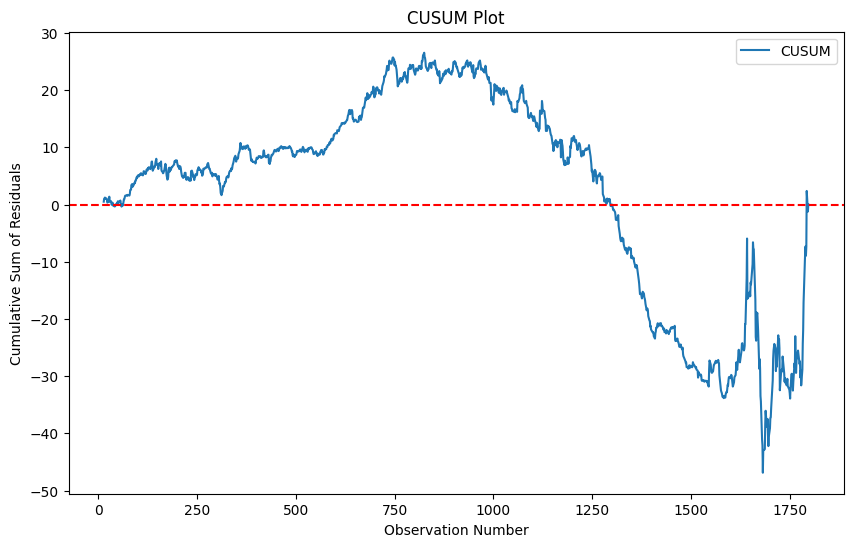

In [16]:
# Fitting des OLS-Modells ohne Dummy-Variablen
X_base = df[['sentiment_numeric', 'likes_count', 'retweets_count', 'replies_count']]
X_base = sm.add_constant(X_base)  # Konstante hinzufügen
y = df['Close_diff']

# OLS-Modell schätzen
model_base = sm.OLS(y, X_base).fit()

# CUSUM-Test durchführen
cusum = breaks_cusumolsresid(model_base.resid, ddof=1)
print(f"CUSUM-Test statistic: {cusum[0]}")
print(f"p-value: {cusum[1]}")

# Manuelle Berechnung der kumulierten Summe der Residuen
cusum_resid = np.cumsum(model_base.resid)

# Plotten der kumulierten Summe der Residuen
plt.figure(figsize=(10, 6))
plt.plot(cusum_resid, label='CUSUM')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('CUSUM Plot')
plt.xlabel('Observation Number')
plt.ylabel('Cumulative Sum of Residuals')
plt.legend()
plt.show()


CUSUM-Teststatistik und p-Wert:
Die CUSUM-Teststatistik von 1.205 und ein p-Wert von 0.109 deuten darauf hin, dass auf einem 5%-Niveau keine statistisch signifikanten Strukturbrüche festgestellt werden können. Ein p-Wert von 0.109 bedeutet, dass die Wahrscheinlichkeit, dass kein Strukturbruch vorliegt, relativ hoch ist. Dennoch ist der Wert nah genug, dass es nicht völlig ausgeschlossen ist, dass es kleinere oder weniger signifikante Brüche gibt.

CUSUM-Plot:
Der Plot zeigt einige deutliche Abweichungen, insbesondere:
Zwischen 1200 und 1800: Ein signifikanter Abwärtstrend in den kumulierten Residuen, was auf eine Phase mit bedeutenden Änderungen hindeutet.
Zwischen 1600 und 1800: Erhebliche Schwankungen, die auf eine instabile Phase hindeuten könnten.

In [17]:
# Dummy-Variablen für Strukturbrüche erstellen
df['dummy_1200_1800_Pandemie'] = ((df.index >= 1200) & (df.index <= 1800)).astype(int)
df['dummy_1600_1800_info_S&P'] = ((df.index >= 1600) & (df.index <= 1800)).astype(int)

# Überprüfen der Dummy-Variablen
print(df[['dummy_1200_1800_Pandemie', 'dummy_1600_1800_info_S&P']].tail(20))


      dummy_1200_1800_Pandemie  dummy_1600_1800_info_S&P
1769                         1                         1
1770                         1                         1
1771                         1                         1
1772                         1                         1
1775                         1                         1
1776                         1                         1
1777                         1                         1
1778                         1                         1
1779                         1                         1
1782                         1                         1
1783                         1                         1
1784                         1                         1
1785                         1                         1
1789                         1                         1
1790                         1                         1
1791                         1                         1
1792                         1 

# 4. Überprüfung Multikollinearität

### VIF-Test

VIF = 1: Keine Korrelation mit den anderen Variablen (keine Multikollinearität).
VIF > 1: Geringe Korrelation mit den anderen Variablen (leichte Multikollinearität).
VIF > 5 oder 10: Hohe Korrelation mit den anderen Variablen (starke Multikollinearität), was in der Regel ein Problem darstellt und weitere Maßnahmen erfordert, wie die Entfernung oder Kombination von Variablen.

In [18]:
# Berechnung der VIF-Werte für die neuen Variablen
X_with_dummies = df[['sentiment_numeric', 'likes_count', 'retweets_count', 'replies_count',
                     'dummy_1200_1800_Pandemie', 'dummy_1600_1800_info_S&P']]
X_with_dummies = sm.add_constant(X_with_dummies)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_dummies.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_dummies.values, i) for i in range(len(X_with_dummies.columns))]

print(vif_data)

                   Variable        VIF
0                     const   1.535344
1         sentiment_numeric   1.007200
2               likes_count  10.120096
3            retweets_count   6.587944
4             replies_count   3.618035
5  dummy_1200_1800_Pandemie   1.597373
6  dummy_1600_1800_info_S&P   1.413899


Multikollinearität (VIF-Werte):
Die VIF-Werte für die Dummy-Variablen sind niedrig, was gut ist. Es gibt keine Hinweise auf problematische Multikollinearität in den Dummy-Variablen.
likes_count zeigt weiterhin einen VIF-Wert über 10, was auf moderate Multikollinearität hinweist. Da diese Variable jedoch signifikant ist und eine starke theoretische Grundlage hat, ist das tolerierbar.

# Einfache lineares Regressionsmodell (OLS - Ordinary Least Squares)
### Ohne Heteroskedastizität Handeln

Nur zum Vergleichen


In [19]:
y = df['Close_diff']
# OLS-Modell schätzen
model_with_dummies = sm.OLS(y, X_with_dummies).fit()
print(model_with_dummies.summary())

                            OLS Regression Results                            
Dep. Variable:             Close_diff   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     11.56
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.18e-12
Time:                        09:17:00   Log-Likelihood:                -2007.5
No. Observations:                1372   AIC:                             4029.
Df Residuals:                    1365   BIC:                             4066.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Das Modell erklärt nur einen kleinen Teil der Varianz in der abhängigen Variable und weist auf statistische Signifikanz bei einigen Prädiktoren hin. Allerdings gibt es Anzeichen für Multikollinearität und mögliche Probleme mit der Normalverteilung der Residuen, was die Zuverlässigkeit der Schätzungen beeinträchtigen könnte.

R-squared (Bestimmtheitsmaß): etwa 4,8 % sehr niedrig und deutet darauf hin, dass das Modell nur einen kleinen Teil der Variation in den Schlusskursveränderungen erklärt.

Der F-Wert von 11.56 zeigt, dass das Modell insgesamt statistisch signifikant ist.

Omnibus und Jarque-Bera-Tests zeigen, dass die Residuen des Modells nicht normal verteilt sind (signifikante p-Werte), was auf Probleme mit der Modellanpassung hinweisen könnte.

Ein hoher Condition Number Wert (über 30) deutet auf mögliche Probleme mit Multikollinearität hin, was bedeutet, dass einige der unabhängigen Variablen stark miteinander korreliert sein könnten.


# 5. Heteroskedastizität Handeln
### Robuste Standardfehler

Jetzt, da das Modell gut spezifiziert ist und die Dummy-Variablen signifikant sind, wäre es sinnvoll, robuste Standardfehler anzuwenden, um sicherzustellen, dass die Signifikanztests robust gegenüber möglichen Heteroskedastizität sind.


In [20]:
# Anwendung robuster Standardfehler (White-Huber)
robust_model = model_with_dummies.get_robustcov_results()
print(robust_model.summary())


                            OLS Regression Results                            
Dep. Variable:             Close_diff   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.575
Date:                Thu, 05 Sep 2024   Prob (F-statistic):             0.0175
Time:                        09:17:00   Log-Likelihood:                -2007.5
No. Observations:                1372   AIC:                             4029.
Df Residuals:                    1365   BIC:                             4066.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Nach der Anwendung robuster Standardfehler (White-Huber) gibt es einige wichtige Unterschiede im Vergleich zum ursprünglichen Modell:

Verbesserungen:
Signifikanzniveau (P-Werte):
likes_count: Der P-Wert für likes_count hat sich von 0.000 auf 0.033 erhöht, bleibt aber immer noch signifikant. Der Effekt bleibt also signifikant, jedoch ist die Signifikanz schwächer geworden.
retweets_count: Der P-Wert für retweets_count ist von 0.000 auf 0.010 gestiegen, was ebenfalls eine Abschwächung der Signifikanz zeigt, aber die Variable bleibt signifikant.
dummy_1200_1800_Pandemie: Der P-Wert ist von 0.044 auf 0.036 gesunken, was bedeutet, dass der Effekt nun etwas stärker signifikant ist.
sentiment_numeric: Der P-Wert hat sich von 0.112 auf 0.066 verringert, bleibt aber immer noch nicht signifikant.


dummy_1600_1800_info_S&P: Der P-Wert hat sich von 0.001 auf 0.112 erhöht, wodurch dieser Koeffizient nicht mehr signifikant ist.

Die robuste Standardfehlerkorrektur hat die Signifikanz einiger Variablen reduziert und die Gesamtmodell-Signifikanz verringert. Dies deutet darauf hin, dass einige der ursprünglichen Signifikanzen möglicherweise durch Heteroskedastizität beeinflusst waren. Andererseits zeigt sich bei der Variablen dummy_1200_1800_Pandemie eine leicht stärkere Signifikanz. Insgesamt bleibt das Modell signifikant, aber die Interpretation der Koeffizienten ist mit robusterer Unsicherheit behaftet.

Wir schauen mal andere Modelle, die ehe mehr geeignet für Zeitreihen

# 6. Modell der partiellen Anpassung
Hier wird ein Modell der partiellen Anpassung verwendet, das Verzögerungseffekte und die Reaktion auf exogene Schocks berücksichtigt.

                            AutoReg Model Results                             
Dep. Variable:             Close_diff   No. Observations:                 1372
Model:                   AutoReg-X(5)   Log Likelihood               -1991.233
Method:               Conditional MLE   S.D. of innovations              1.038
Date:                Thu, 05 Sep 2024   AIC                           4010.465
Time:                        09:17:00   BIC                           4083.550
Sample:                             5   HQIC                          4037.819
                                 1372                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0016      0.017     -0.094      0.925      -0.036       0.033
Close_diff.L1                0.0379      0.027      1.420      0.155      -0.014       0.

/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


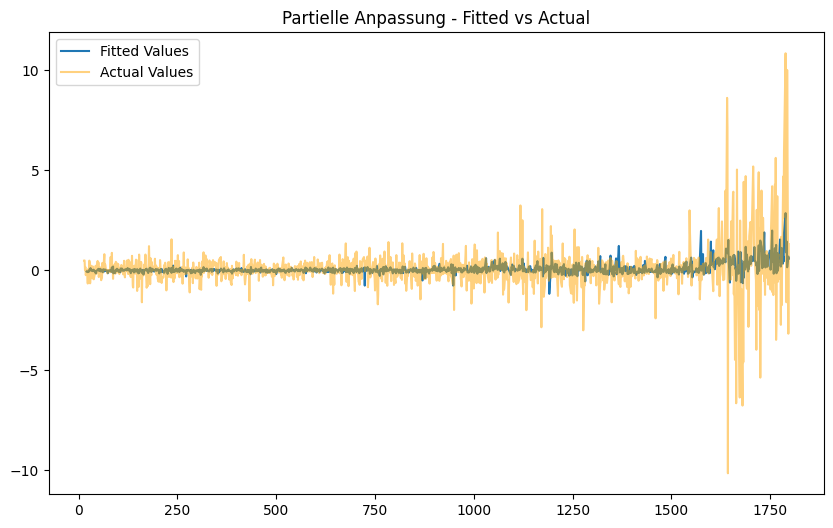

In [21]:
# Modellierung der partiellen Anpassung
lags = 5  # Anzahl der Lags, die berücksichtigt werden sollen
ar_model = AutoReg(df['Close_diff'].dropna(), lags=lags, exog=X_with_dummies)
ar_result = ar_model.fit()

print(ar_result.summary())

# Plot der Residuen und Modellgüte
plt.figure(figsize=(10, 6))

# Plot Fitted Values
plt.plot(ar_result.fittedvalues, label="Fitted Values")

# Plot Actual Values with transparent orange color
plt.plot(df['Close_diff'].dropna(), label="Actual Values", color="orange", alpha=0.5)

plt.legend()
plt.title('Partielle Anpassung - Fitted vs Actual')
plt.show()


Das Modell der partiellen Anpassung bietet eine verbesserte Modellierung, indem es die Dynamik der Zeitreihen berücksichtigt. Einige Lags und exogene Variablen sind signifikant, was auf eine gewisse Persistenz und exogene Einflüsse auf die Schlusskursveränderungen hinweist. Das Modell liefert eine differenziertere und wahrscheinlich genauere Vorhersage im Vergleich zu einem einfachen OLS-Modell.


Autoregressive Lags:
Close_diff.L3: Der dritte Lag ist signifikant (p-Wert = 0.000) mit einem positiven Effekt, was bedeutet, dass die Schlusskursveränderungen von vor drei Perioden einen signifikanten Einfluss auf die aktuelle Schlusskursveränderung haben.
Andere Lags (L1, L2, L4, L5) sind nicht signifikant.
Exogene Variablen:
likes_count und retweets_count bleiben signifikant (P-Werte = 0.000), mit einem positiven bzw. negativen Einfluss, ähnlich wie im vorherigen Modell.
dummy_1200_1800_Pandemie und dummy_1600_1800_info_S&P sind weiterhin signifikant, was auf einen Einfluss von Pandemiebeschränkungen und S&P 500 Informationen auf die Kursveränderungen hinweist.
Modellgüte:
Log-Likelihood, AIC, BIC: Das Modell zeigt relativ hohe Modellgüte-Maße, was auf eine bessere Anpassung im Vergleich zum einfachen OLS-Modell hinweist.
Roots Analysis: Die Analyse der Wurzeln zeigt, dass das Modell stabil ist (alle Moduli liegen innerhalb des Einheitskreises).

# 6. ARIMA-Modell (Einfach ohne Exogene Variablen)

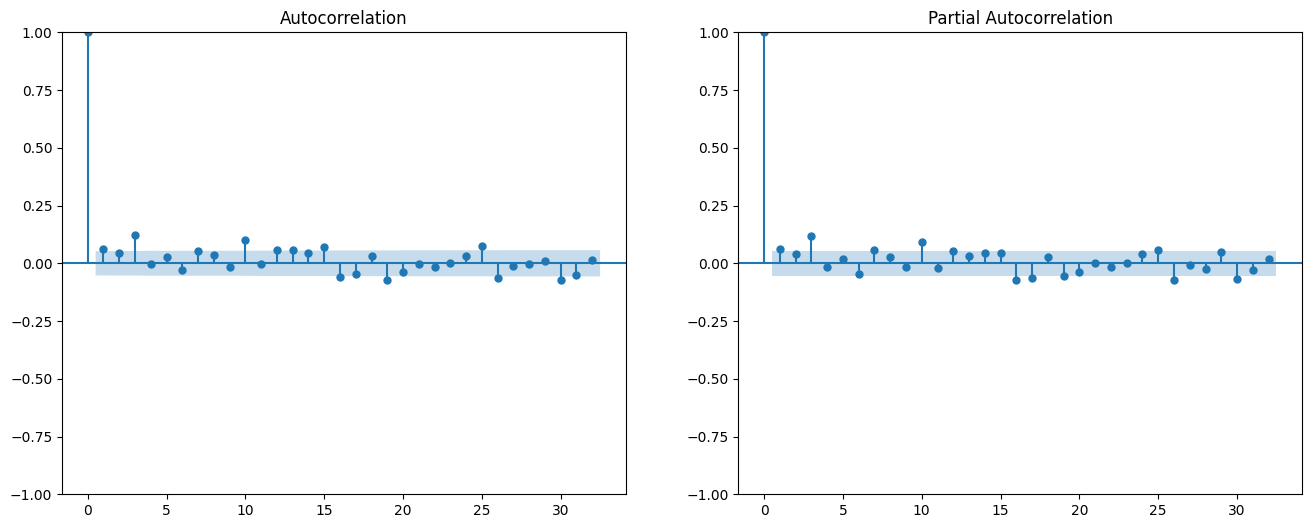

In [22]:
# Plot der ACF und PACF der differenzierten Serie
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Close_diff'].dropna(), ax=ax[0])
plot_pacf(df['Close_diff'].dropna(), ax=ax[1])
plt.show()


Die Plots der Autokorrelationsfunktion (ACF) und der partiellen Autokorrelationsfunktion (PACF) geben Aufschluss darüber, welche Parameter für das ARIMA-Modell gewählt werden sollten:

Autokorrelationsfunktion (ACF):
Der erste Lag in der ACF zeigt eine signifikante Korrelation, die danach schnell abfällt und nahe Null bleibt. Dies deutet darauf hin, dass eine gleitende Durchschnittskomponente (q) von 1 sinnvoll sein könnte.
Partielle Autokorrelationsfunktion (PACF):
Die PACF zeigt ebenfalls eine signifikante Korrelation bei Lag 1, danach fällt sie schnell ab. Dies spricht dafür, eine autoregressive Komponente (p) von 1 zu wählen.

/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1372
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2032.865
Date:                Thu, 05 Sep 2024   AIC                           4071.729
Time:                        09:17:00   BIC                           4087.399
Sample:                             0   HQIC                          4077.593
                               - 1372                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0319      0.012      2.671      0.008       0.008       0.055
ma.L1         -0.9818      0.003   -325.562      0.000      -0.988      -0.976
sigma2         1.1334      0.011    102.978      0.0

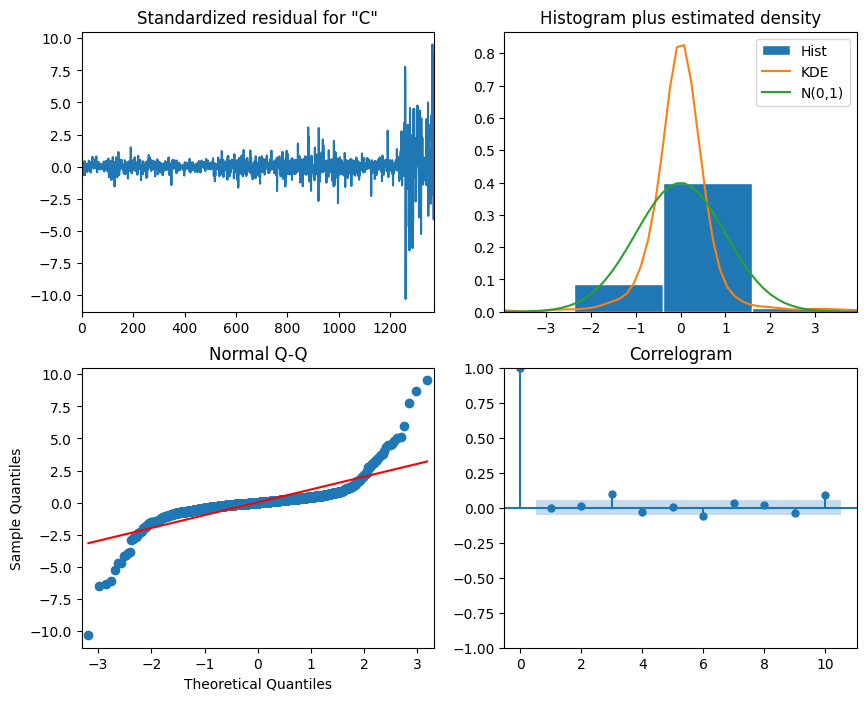

In [23]:
# Schätzen des ARIMA-Modells mit p=1, d=1, q=1
p = 1
d = 1
q = 1

arima_model = sm.tsa.ARIMA(df['Close_diff'].dropna(), order=(p, d, q))
arima_result = arima_model.fit()

# Ergebnisse anzeigen
print(arima_result.summary())

# Residuen plotten
arima_result.plot_diagnostics(figsize=(10, 8))
plt.show()

In [24]:
# Automatische Auswahl der besten ARIMA-Parameter
auto_arima_model = auto_arima(df['Close_diff'].dropna(), seasonal=False, trace=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4949.464, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4571.240, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4071.732, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4947.464, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4072.384, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4072.418, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4069.240, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4070.834, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4074.278, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4074.056, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4054.789, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4065.997, Time=0.53 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=i

Mit automatischen Auswahl sieht man Verbesserungen.
Unterschiede und Bewertung in ARIMA:
Modellkomplexität:
Das ARIMA-Modell (2,1,3) ist komplexer als das AutoReg-Modell, da es zwei autoregressive (AR) und drei gleitende Mittelwert (MA) Komponenten enthält.
Dies spiegelt sich in den Parametern wider: ar.L1, ar.L2 und ma.L1, ma.L2, ma.L3, die alle signifikant sind (p-Werte = 0.000).

Modellgüte (AIC und BIC):
Das ARIMA-Modell hat einen AIC von 4054.789 und einen BIC von 4091.352. Diese Werte sind niedriger als bei den einfacheren Modellen, was auf eine bessere Modellanpassung hindeutet.

Signifikanz der Parameter:
Alle AR- und MA-Parameter sind hoch signifikant, was darauf hindeutet, dass die vergangenen Werte der Serie und die Fehlerterme in den Vorhersagen eine wichtige Rolle spielen.
Der intercept ist nicht signifikant (P-Wert = 0.272), was darauf hindeutet, dass der konstante Term nicht notwendig ist.

Residuenanalyse:
Ljung-Box-Test zeigt keine signifikante Autokorrelation in den Residuen (Prob(Q) = 0.20), was ein gutes Zeichen für die Modellanpassung ist.
Jarque-Bera-Test: Die hohe Kurtosis und der signifikante p-Wert zeigen jedoch, dass die Residuen nicht normal verteilt sind, ähnlich wie in den vorherigen Modellen.

Heteroskedastizität: Das Modell zeigt eine erhebliche Heteroskedastizität (H = 21.17), was darauf hinweist, dass die Varianz der Residuen nicht konstant ist.

Fazit:
Das ARIMA-Modell ist komplexer und bietet eine bessere Anpassung (niedrigere AIC- und BIC-Werte) im Vergleich zu einfacheren autoregressiven Modellen. Allerdings zeigt es immer noch Probleme wie nicht-normal verteilte und heteroskedastische Residuen. Es ist besser geeignet für die Modellierung von Zeitreihen ohne exogene Variablen, aber die Analyse der Residuen deutet darauf hin, dass weitere Verbesserungen möglich sein könnten.

# 7. ARIMAX-Modellierung mit Lags
Wir führen eine ARIMAX-Modellierung durch, die Lags für die Verzögerungseffekte einbezieht.

/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsm

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1372
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2045.322
Date:                Thu, 05 Sep 2024   AIC                           4116.645
Time:                        09:17:07   BIC                           4184.547
Sample:                             0   HQIC                          4142.055
                               - 1372                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                             0        nan        nan        nan         nan         nan
sentiment_numeric            0.0670      0.077      0.869      0.385      -0.084       0.

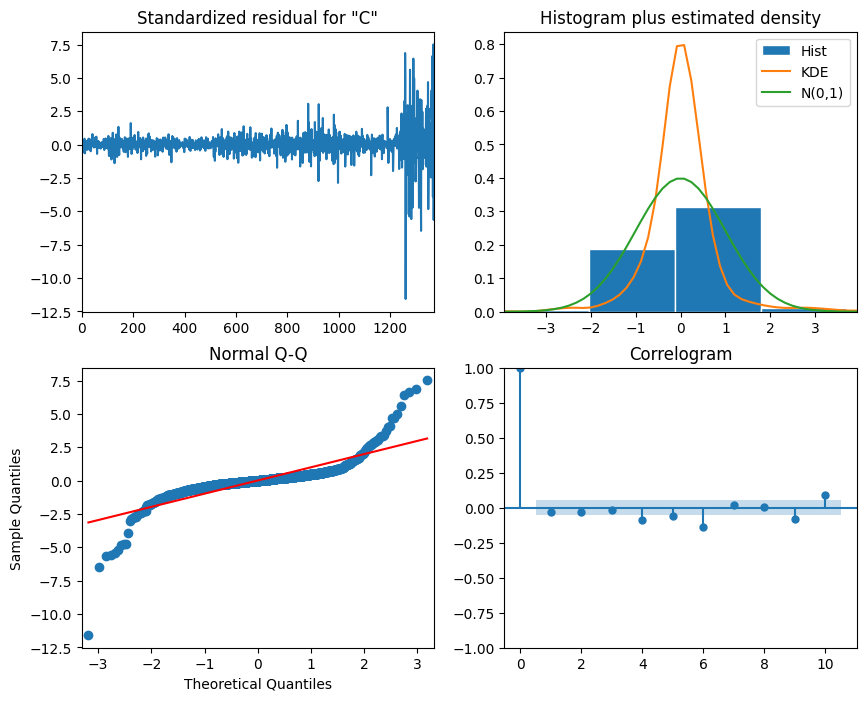

In [25]:
# Schätzung des ARIMAX-Modells mit Lags und exogenen Variablen
arimax_model = ARIMA(df['Close_diff'].dropna(), order=(2,1,3), exog=X_with_dummies)
arimax_result = arimax_model.fit()

# Ergebnisse anzeigen
print(arimax_result.summary())

# Plot der Residuen
arimax_result.plot_diagnostics(figsize=(10, 8))
plt.show()

Das ARIMAX-Modell (2,1,3) mit exogenen Variablen erweitert das vorherige ARIMA-Modell durch die Einbeziehung zusätzlicher Prädiktoren wie sentiment_numeric, likes_count, und Dummy-Variablen. Hier sind die wesentlichen Unterschiede und Interpretationen:

Verbesserungen:

Berücksichtigung exogener Variablen:

Einige der exogenen Variablen sind signifikant:
likes_count: Signifikant mit einem positiven Effekt (p-Wert = 0.001).
retweets_count: Signifikant mit einem negativen Effekt (p-Wert = 0.003).
replies_count: Stark signifikant mit einem positiven Effekt (p-Wert = 0.000).
Dies zeigt, dass bestimmte exogene Faktoren, wie die Anzahl der Likes, Retweets und Antworten, einen Einfluss auf die Schlusskursveränderungen haben.

Nachteile und Herausforderungen:

Modellkomplexität und Konvergenzprobleme:
Das Modell hatte Konvergenzprobleme, was durch die Warnung "Maximum Likelihood optimization failed to converge" angezeigt wird. Dies kann die Zuverlässigkeit der Schätzungen beeinträchtigen.
Die Kovarianzmatrix ist möglicherweise instabil ("Covariance matrix is singular or near-singular"), was auf numerische Probleme und potenziell ungenaue Standardfehler hinweist.

Nicht-signifikante Parameter:
sentiment_numeric, dummy_1200_1800_Pandemie, und dummy_1600_1800_info_S&P sind nicht signifikant. Diese Variablen tragen in diesem Modell nicht wesentlich zur Erklärung der Schlusskursveränderungen bei.

Modellgüte (AIC und BIC):
Das ARIMAX-Modell hat einen höheren AIC (4116.645) und BIC (4184.547) im Vergleich zum reinen ARIMA-Modell. Dies deutet darauf hin, dass die zusätzliche Komplexität durch die exogenen Variablen nicht zu einer besseren Modellanpassung geführt hat.

Residuenanalyse:
Die Residuen zeigen weiterhin Heteroskedastizität (H = 20.90) und eine starke Nicht-Normalität (Jarque-Bera p-Wert = 0.00), was auf verbleibende Modellierungsprobleme hinweist.

Fazit:
Das ARIMAX-Modell berücksichtigt wichtige exogene Variablen, aber es leidet unter Konvergenzproblemen und führt zu einer weniger robusten Modellanpassung im Vergleich zum einfacheren ARIMA-Modell. Trotz der zusätzlichen Erklärungsfaktoren, die signifikant sind, führt die erhöhte Modellkomplexität zu numerischen Herausforderungen und einer insgesamt schlechteren Modellgüte.

# Multikoliniarität Eleminieren
Da unser Modell nicht mit alles Anzahl von likes, retweets und replies nicht gut umgehen könnte, ist eine Eleminierung der Multikoliniarität nötwendig.

###  Principal Component Analysis (PCA)

Um Multikoliniarität zwischen Anzahl der Likes, Retweets und Replies zu handeln. Da die interpretabilität nicht so für diese Features in unserem Fall nicht so relevaz, ist PCA am besten geeignet, um Multikoliniarität zu eleminieren.

In [26]:
# Wähle die Social-Media-Variablen aus
social_media_vars = df[['likes_count', 'retweets_count', 'replies_count']]

# Standardisiere die Daten
scaler = StandardScaler()
social_media_scaled = scaler.fit_transform(social_media_vars)

# Führe PCA durch
pca = PCA(n_components=1)  # Wir verwenden nur die erste Hauptkomponente
social_media_pca = pca.fit_transform(social_media_scaled)

# Füge die PCA-Komponente zum DataFrame hinzu
df['social_engagement_pca'] = social_media_pca

In [27]:

# Erstelle das ARIMAX-Modell mit der neuen PCA-Komponente
X_pca = df[['sentiment_numeric', 'social_engagement_pca', 'dummy_1200_1800_Pandemie', 'dummy_1600_1800_info_S&P']]
y = df['Close_diff']

# ARIMAX-Modell mit PCA-Komponente
arimax_model_pca = sm.tsa.ARIMA(y, order=(2,1,3), exog=X_pca)
arimax_result_pca = arimax_model_pca.fit()

# Zeige die Ergebnisse
print(arimax_result_pca.summary())


/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1372
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2007.855
Date:                Thu, 05 Sep 2024   AIC                           4035.710
Time:                        09:17:09   BIC                           4087.943
Sample:                             0   HQIC                          4055.256
                               - 1372                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
sentiment_numeric            0.0908      0.074      1.230      0.219      -0.054       0.235
social_engagement_pca        0.0699      0.009      8.068      0.000       0.053       0.

/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
df.head()

,Date,Adj Close,Volume,sentiment_numeric,likes_count,retweets_count,replies_count,Close_diff,dummy_1200_1800_Pandemie,dummy_1600_1800_info_S&P,social_engagement_pca
14,2015-02-02,14.062667,62238000.0,0.0,0.0,0.0,0.0,0.489334,0,0,-0.763154
15,2015-02-03,14.557333,72393000.0,0.0,0.0,0.0,0.0,0.494666,0,0,-0.763154
16,2015-02-04,14.570000,49581000.0,0.0,0.0,0.0,0.0,0.012667,0,0,-0.763154
17,2015-02-05,14.732667,52843500.0,0.0,0.0,0.0,0.0,0.162667,0,0,-0.763154
18,2015-02-06,14.490667,48658500.0,0.0,0.0,0.0,0.0,-0.242000,0,0,-0.763154


In [34]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Grundlegendes ARIMAX-Modell mit PCA
X_pca = df[['sentiment_numeric', 'social_engagement_pca', 'dummy_1600_1800_info_S&P']]
y = df['Close_diff']

# Füge eine Konstante zu X_pca hinzu
X_pca_const = sm.add_constant(X_pca)

# Methode 1: Originales Modell ohne Anpassung
arimax_model_pca = sm.tsa.ARIMA(y, order=(2, 1, 3), exog=X_pca_const)
arimax_result_pca = arimax_model_pca.fit()

# Methode 2: Anwendung robuster Standardfehler (White-Huber)
arimax_model_robust = sm.tsa.ARIMA(y, order=(2, 1, 3), exog=X_pca_const)
arimax_result_robust = arimax_model_robust.fit(cov_type='robust')

# Methode 3: Box-Cox-Transformation der abhängigen Variablen, um die Varianz zu stabilisieren
from scipy import stats
y_boxcox, lambda_value = stats.boxcox(y + abs(y.min()) + 1)  # Box-Cox erfordert positive Werte

# Erneutes Modell mit transformierter abhängiger Variable
arimax_model_boxcox = sm.tsa.ARIMA(y_boxcox, order=(2, 1, 3), exog=X_pca_const)
arimax_result_boxcox = arimax_model_boxcox.fit()

# Methode 4: Log-Transformation der abhängigen Variablen
y_log = np.log(y + abs(y.min()) + 1)  # Log-Transformation erfordert ebenfalls positive Werte
arimax_model_log = sm.tsa.ARIMA(y_log, order=(2, 1, 3), exog=X_pca_const)
arimax_result_log = arimax_model_log.fit()

# Breusch-Pagan-Test für Heteroskedastizität (für Originalmodell)
bp_test = het_breuschpagan(arimax_result_pca.resid, X_pca_const)
labels = ['LM-Statistik', 'LM-Test p-Wert', 'F-Statistik', 'F-Test p-Wert']
bp_result = dict(zip(labels, bp_test))

# Vergleich der Ergebnisse
print("Originalmodell:")
print(arimax_result_pca.summary())
print("\nModell mit robusten Standardfehlern:")
print(arimax_result_robust.summary())
print("\nModell mit Box-Cox-Transformation:")
print(arimax_result_boxcox.summary())
print(f"\nLambda-Wert der Box-Cox-Transformation: {lambda_value}")
print("\nModell mit Log-Transformation:")
print(arimax_result_log.summary())
print("\nBreusch-Pagan-Test:")
print(bp_result)


/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsm

Originalmodell:
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1372
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2008.237
Date:                Thu, 05 Sep 2024   AIC                           4036.474
Time:                        09:51:22   BIC                           4088.707
Sample:                             0   HQIC                          4056.021
                               - 1372                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -3.032e-07   4.64e-11  -6535.464      0.000   -3.03e-07   -3.03e-07
sentiment_numeric            0.0873      0.074      1.186      0.236     

/Users/reebal/FH-Wedel/SS24/Ökonometrie/my-projects/140-Characters-and-Billion-Dollar-Moves/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
